In [1]:
import yfinance as yf
import os
import questionary
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.common import URL
from MCForecastTools import MCSimulation
from datetime import datetime, timedelta

%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv(".\\SAMPLE.env")

True

In [3]:
btc = yf.Ticker("BTC-USD")

In [4]:
btc_hist = btc.history(period="3y")

In [5]:
btc_price_df = pd.DataFrame(btc_hist["Close"])
btc_price_df.dropna().copy()
btc_price_df["Close"] = btc_price_df["Close"].astype("float")

In [128]:
#monthly_investment = questionary.text("How much money would you like to invest monthly (50/50 split)?").ask()
monthly_investment = "1000"
monthly_investment = float(monthly_investment)

In [129]:
btc_investment = monthly_investment / 2
print(f"Monthly BTC Investment: ${btc_investment:.2f}")

Monthly BTC Investment: $500.00


In [130]:
btc_coins_list = []

for price in btc_price_df['Close']:
    btc_coins = btc_investment / price
    btc_coins_list.append(btc_coins)

In [131]:
btc_price_df['Coins'] = btc_coins_list
btc_coins_df = pd.DataFrame(btc_price_df["Coins"])
btc_coins_df.reset_index(inplace=True)
btc_coins_df = btc_coins_df.rename(columns = {'index':'Date'})

In [132]:
btc_period = btc_coins_df.Date.dt.to_period("M")
avg_btc_coins_df = btc_coins_df.groupby(btc_period)['Coins'].mean()
total_btc_coins = avg_btc_coins_df.sum()
print(f"Total Current Bitcoin Coins: {total_btc_coins:.5f}")

Total Current Bitcoin Coins: 1.15578


In [133]:
btc_current_price = btc_price_df["Close"].iloc[-1]
print(f"Current Bitcoin Price: ${btc_current_price:.2f}") 
btc_usd_wallet = total_btc_coins * btc_current_price
print(f"Total Bitcoin Wallet (USD): ${btc_usd_wallet:.2f}")

Current Bitcoin Price: $21386.80
Total Bitcoin Wallet (USD): $24718.46


In [134]:
spy = yf.Ticker("SPY")

In [135]:
spy_hist = spy.history(period="3y")

In [136]:
spy_price_df = pd.DataFrame(spy_hist["Close"])
spy_price_df.dropna().copy()
spy_price_df["Close"] = spy_price_df["Close"].astype("float")

In [137]:
spy_investment = monthly_investment / 2
print(f"Monthly SPY Investment: ${spy_investment:.2f}")

Monthly SPY Investment: $500.00


In [138]:
spy_shares_list = []

for price in spy_price_df['Close']:
    spy_shares = spy_investment / price
    spy_shares_list.append(spy_shares)
    

In [139]:
spy_price_df['Shares'] = spy_shares_list
spy_shares_df = pd.DataFrame(spy_price_df["Shares"])
spy_shares_df.reset_index(inplace=True)
spy_shares_df = spy_shares_df.rename(columns = {'index':'Date'})

In [140]:
spy_period = spy_shares_df.Date.dt.to_period("M")
avg_spy_shares_df = spy_shares_df.groupby(spy_period)['Shares'].mean()
total_spy_shares = avg_spy_shares_df.sum()
print(f"Total Current S&P 500 ETF Shares: {total_spy_shares:.5f}")

Total Current S&P 500 ETF Shares: 52.07241


In [141]:
spy_current_price = spy_price_df["Close"].iloc[-1]
print(f"Current S&P 500 ETF Price: ${spy_current_price:.2f}")  
spy_usd_wallet = total_spy_shares * spy_current_price
print(f"Total S&P 500 ETF Wallet (USD): ${spy_usd_wallet:.2f}")

Current S&P 500 ETF Price: $412.35
Total S&P 500 ETF Wallet (USD): $21472.06


In [142]:
total_portfolio = btc_usd_wallet + spy_usd_wallet
print(f"Total Value of Portfolio (USD): ${total_portfolio:.2f}")

Total Value of Portfolio (USD): $46190.52


In [143]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca tradeapi.REST object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    URL('https://paper-api.alpaca.markets'),
    api_version = "v2"
)

In [144]:
# Set the tickers for both the bond and stock portion of the portfolio
spy = ["SPY"]

# Set timeframe to 1Day
timeframe = "1Day"

today = datetime.today()
yesterday = today - timedelta(days=1)
three_years = today - timedelta(days=756)

sdate = three_years.strftime("%Y-%m-%d")
edate = yesterday.strftime("%Y-%m-%d")


start_date = pd.Timestamp(sdate, tz="America/New_York").isoformat()
end_date = pd.Timestamp(edate, tz="America/New_York").isoformat()

In [145]:
# Use the Alpaca get_bars function to get current closing prices the portfolio
# Be sure to set the `df` property after the function to format the response object as a DataFrame
spy_data = api.get_bars(
    spy,
    timeframe,
    start_date,
    end_date
).df

spy_data.index = spy_data.index.strftime('%Y-%m-%d')
# Reorganize the DataFrame
SPY = spy_data[spy_data['symbol']=='SPY'].drop('symbol', axis=1)


# Review the first 5 rows of the Alpaca DataFrame
SPY.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2020-07-29,322.14,325.73,322.075,325.12,48454159,275881,323.937307
2020-07-30,321.90,324.41,319.640,323.96,61861788,397283,322.845066
2020-07-31,326.00,326.63,321.330,326.52,85211555,448876,324.494578
2020-08-03,328.31,329.62,327.730,328.79,53078112,288003,328.658795
2020-08-04,327.88,330.06,327.860,330.06,41917896,250899,329.057592


In [146]:
btc = ["BTCUSD"]

bitcoin_data = api.get_crypto_bars(
     btc, 
     timeframe,
     start_date,
     end_date
).df

bitcoin_data.index = bitcoin_data.index.strftime('%Y-%m-%d')
#bitcoin_data.head()
BTC = bitcoin_data[bitcoin_data['exchange']=='CBSE'].drop(['exchange','symbol'], axis=1)

BTC.tail()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-08-18,23379.04,23600.00,22712.22,22787.49,16656.303422,577763,23232.073186
2022-08-19,22789.49,22835.53,20782.39,21244.91,46606.469108,1004800,21446.285151
2022-08-20,21243.75,21372.93,20760.93,21200.14,18975.526149,689261,21169.806012
2022-08-21,21200.14,21795.08,21067.33,21468.38,16745.547484,603324,21433.214216
2022-08-22,21468.33,21540.00,20889.69,21266.93,25643.744102,694327,21220.571293


In [147]:
prices_df = pd.concat([BTC,SPY],axis=1, keys=['BTC','SPY'])
prices_df = prices_df.dropna().copy()

In [148]:
MC_tenyear_aggressive = MCSimulation(
    portfolio_data=prices_df,
    weights=[0.80, 0.20],
    num_simulation=500,
    num_trading_days=252*10,
)

# Review the simulation input data
MC_tenyear_aggressive.portfolio_data

BTC                                                          \
                open      high       low     close        volume trade_count   
timestamp                                                                      
2020-07-29  10951.76  11350.00  10920.01  11110.12  15426.566781    109844.0   
2020-07-30  11115.99  11148.28  10975.00  11067.62   1948.135936     23599.0   
2020-07-31  11067.63  11460.00  11044.49  11351.62  13697.898587    107668.0   
2020-08-03  11233.16  11417.11  11222.00  11319.07   2337.001514     26352.0   
2020-08-04  11197.05  11265.74  11073.70  11253.61   1926.660006     19656.0   
...              ...       ...       ...       ...           ...         ...   
2022-08-16  23962.61  24153.58  23668.00  24069.75  18926.543068    622752.0   
2022-08-17  24072.26  24448.49  23180.14  23379.04  21507.482650    556575.0   
2022-08-18  23379.04  23600.00  22712.22  22787.49  16656.303422    577763.0   
2022-08-19  22789.49  22835.53  20782.39  21244.91  46606.469108   1004800.0   
2022-08-22  21468.33  21540.00  20889.69  21266.93  25643.744102    694327.0   

                                          SPY                           \
                    vwap daily_return    open    high      low   close   
timestamp                                                                
2020-07-29  11153.892818          NaN  322.14  325.73  322.075  325.12   
2020-07-30  11031.741379    -0.003825  321.90  324.41  319.640  323.96   
2020-07-31  11275.251680     0.025660  326.00  326.63  321.330  326.52   
2020-08-03  11319.548902    -0.002867  328.31  329.62  327.730  328.79   
2020-08-04  11185.480901    -0.005783  327.88  330.06  327.860  330.06   
...                  ...          ...     ...     ...      ...     ...   
2022-08-16  23917.823725     0.004467  427.62  431.73  426.880  429.70   
2022-08-17  23599.210786    -0.028696  425.94  429.50  424.540  426.65   
2022-08-18  23232.073186    -0.025303  426.78  428.61  425.500  427.89   
2022-08-19  21446.285151    -0.067694  424.87  425.26  421.220  422.14   
2022-08-22  21220.571293     0.001036  417.04  417.23  412.400  413.35   

                                                             
                volume trade_count        vwap daily_return  
timestamp                                                    
2020-07-29  48454159.0    275881.0  323.937307          NaN  
2020-07-30  61861788.0    397283.0  322.845066    -0.003568  
2020-07-31  85211555.0    448876.0  324.494578     0.007902  
2020-08-03  53078112.0    288003.0  328.658795     0.006952  
2020-08-04  41917896.0    250899.0  329.057592     0.003863  
...                ...         ...         ...          ...  
2022-08-16  59118566.0    410281.0  429.307919     0.001959  
2022-08-17  63266564.0    451881.0  426.965059    -0.007098  
2022-08-18  47948507.0    331980.0  427.137042     0.002906  
2022-08-19  67861630.0    438953.0  423.097019    -0.013438  
2022-08-22  77604197.0    484052.0  415.048519    -0.020822  

[522 rows x 16 columns]

In [149]:
MC_tenyear_aggressive.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 110.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 120.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 130.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 140.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 150.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 160.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 170.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 180.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 190.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 200.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 210.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 220.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 230.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 240.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 250.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 260.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 270.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 280.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 290.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 300.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 310.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 320.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 330.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 340.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 350.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 360.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 370.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 380.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 390.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 400.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 410.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 420.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 430.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 440.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 450.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 460.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 470.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 480.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

Running Monte Carlo simulation number 490.


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcam

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.975634,1.040989,1.048036,0.912449,1.018046,0.988097,1.041323,1.032004,1.000079,0.964502,...,1.008322,0.956640,0.956542,1.054888,0.970888,0.952926,0.989491,1.083776,0.991067,1.038511
2,0.988913,1.052275,0.997564,0.935164,1.041486,1.008930,0.983545,1.125660,0.972530,0.942881,...,1.069819,0.894823,0.958836,1.026134,1.043575,1.023017,0.999237,1.075932,0.965528,1.129863
3,1.002978,1.146840,0.975629,0.916386,1.053594,0.983991,1.001952,1.084779,0.947664,0.913808,...,1.050705,0.911133,0.933456,0.946085,1.071672,1.031724,1.043452,1.046289,1.002928,1.107576
4,0.988244,1.167247,0.942194,0.931168,1.052694,1.046174,0.999140,1.055436,0.914249,0.966949,...,1.022582,0.931948,0.985197,0.929187,1.091085,0.952620,1.059880,0.975732,0.984533,1.060156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,161.189813,4.003112,281.512071,24.292302,1190.736820,20.371626,17.931157,1.938000,36.393672,119.975896,...,399.406992,67.373613,52.492355,0.942667,35.164397,26.449126,84.928331,1.305899,235.057356,1.120306
2517,163.132720,4.167513,290.063055,24.499593,1178.075855,19.787485,18.009274,1.977092,35.194122,128.627109,...,410.324656,66.700778,52.236325,0.939845,33.726065,26.933997,82.129679,1.296937,241.653819,1.105707
2518,161.176783,4.492155,288.318152,24.988948,1128.941172,19.515776,17.411101,1.871867,35.337610,131.882278,...,422.385980,68.464775,55.104861,0.964416,32.310268,26.221290,75.651508,1.321041,237.890701,1.055936
2519,160.970070,4.546948,282.774582,24.556353,1095.740259,20.511181,17.160158,1.833682,34.137783,130.918203,...,456.074797,73.330100,57.547591,0.888063,30.745123,26.105754,70.889007,1.327825,232.085460,1.032276


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

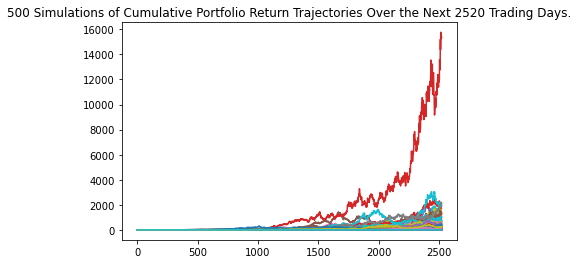

In [150]:
MC_tenyear_aggressive.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

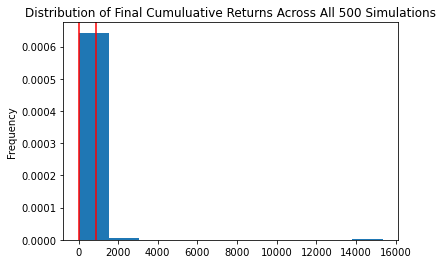

In [151]:
MC_tenyear_aggressive.plot_distribution()

In [152]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable
MC_tenyear_statistics = MC_tenyear_aggressive.summarize_cumulative_return()


# Review the 10-year Monte Carlo summary statistics
print(MC_tenyear_statistics)

count             500.000000
mean              138.320227
std               730.195275
min                 0.065560
25%                 7.293170
50%                23.358387
75%                89.937169
max             15358.639386
95% CI Lower        0.627272
95% CI Upper      903.678643
Name: 2520, dtype: float64


C:\Users\Nia\OneDrive\Desktop\UNCC Fintech Bootcamp\Python\Projects\Project 1\Bitcoin-Advisor-\Project 1\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [154]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_ten_cumulative_return = round(MC_tenyear_statistics[8]*10000,2)
ci_upper_ten_cumulative_return = round(MC_tenyear_statistics[9]*10000,2)

# Print the result of your calculations
print(f"There is a 95% chance that an initial investment of"
      f" $10000 in the portfolio"
      f" over the next 10 years will end within the range of"
      f" ${ci_lower_ten_cumulative_return} and ${ci_upper_ten_cumulative_return}.")

There is a 95% chance that an initial investment of $10000 in the portfolio over the next 10 years will end within the range of $6272.72 and $9036786.43.


In [155]:
# Create a Pandas DataFrame called savings_df 
savings_df = pd.DataFrame(data=[btc_usd_wallet, spy_usd_wallet], columns=['Amount'], index=['Bitcoin', 'S&P 500 ETF'])

<AxesSubplot:title={'center':'Total Value of Portfolio'}, ylabel='Amount'>

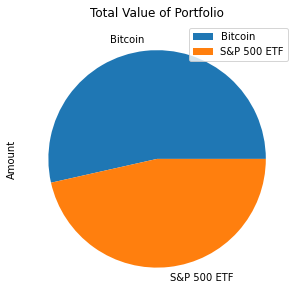

In [156]:
# Plot the total value of the member's portfolio (Bitcoin and S&P 500 ETF) in a pie chart
savings_df.plot.pie(y='Amount',figsize=(5, 5),title="Total Value of Portfolio")

In [157]:
# Generate the summary statistics for the Bitcoin DataFrame
btc_price_df["Close"].describe()

count     1097.000000
mean     27701.332957
std      18103.869806
min       4970.788086
25%       9648.717773
50%      23656.207031
75%      42892.957031
max      67566.828125
Name: Close, dtype: float64

In [158]:
# Generate the summary statistics for the S&P500 ETF DataFrame
spy_price_df["Close"].describe()

count    755.000000
mean     368.510396
std       63.528338
min      215.649414
25%      310.500687
50%      377.569031
75%      427.157288
max      474.182190
Name: Close, dtype: float64

<AxesSubplot:title={'center':'Bitcoin Prices over 3 years'}, xlabel='Date'>

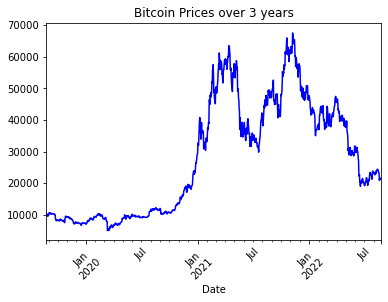

In [159]:
# Create a line plot for the Bitcoin DataFrame for the full length of time in the dataset 
btc_price_df['Close'].plot(figsize=(6,4), rot=45, color="blue", title="Bitcoin Prices over 3 years")

<AxesSubplot:title={'center':'S&P 500 ETF Prices over 3 Years'}, xlabel='Date'>

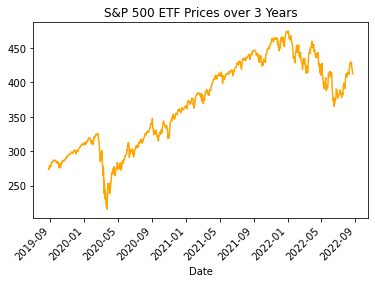

In [161]:
# Create a line plot for the S&P500 ETF DataFrame for the full length of time in the dataset 
spy_price_df['Close'].plot(figsize=(6,4), rot=45, color="orange", title="S&P 500 ETF Prices over 3 Years")

<AxesSubplot:title={'center':'Bitcoin v. S&P500 ETF over 3 Years'}, xlabel='Date'>

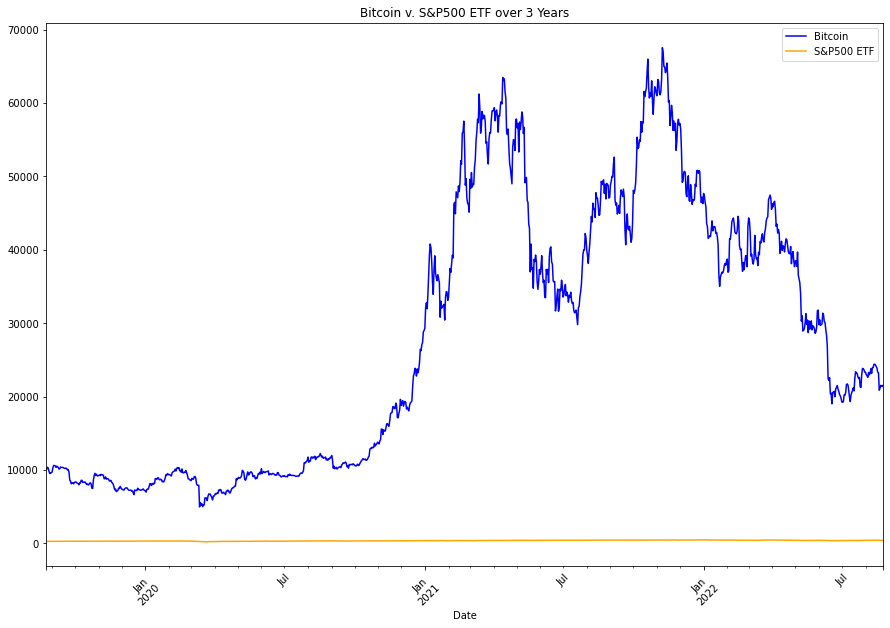

In [162]:
# Overlay the visualizations for the Bitcoin and S&P500 ETF DataFrames in one plot
btc_price_df['Close'].plot(figsize=(15,10), rot=45, color="blue", title="Bitcoin v. S&P 500 ETF over 3 Years", legend="true", label="Bitcoin")
spy_price_df['Close'].plot(figsize=(15,10), rot=45, color="orange", legend="true", label="S&P500 ETF")